In [1]:
import os
import numpy as np
import h5py
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from pytorch_lightning import LightningModule
from sklearn.model_selection import train_test_split

In [2]:
# Path setup
model_path = "best_model_v9-1-SS---epoch=7829-val_loss=0.00008619.ckpt"  
garstec_data = r'C:\Users\kiena\Documents\YEAR 4\PROJECT\Data\Garstec_AS09_chiara.hdf5'
save_dir = r'C:\Users\kiena\Python Project\Year4Project\dev\GarstecModel_V8' 
os.makedirs(save_dir, exist_ok=True)

In [3]:
class GarstecNet(LightningModule):
    def __init__(self, input_dim, output_dim, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),  # First layer maps input_dim to 256 neurons
            nn.LeakyReLU(),
            nn.Linear(512, 256),  # 2
            nn.LeakyReLU(),
            nn.Linear(256, 128),  # 3
            nn.LeakyReLU(),
            nn.Linear(128, 64),  # 4
            nn.LeakyReLU(),
            nn.Linear(64, 32),  # 5
            nn.LeakyReLU(),
            nn.Linear(32, output_dim)  # Output layer
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=False)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=25, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            },
        }

In [4]:
def load_data():
    # 7 Inputs
    ages = []
    massini = []
    fehini = []
    alphamlt = []
    yini = []
    eta = []
    alphafe = []

    # 5 Outputs
    teff = []
    luminosity = []
    dnufit = []
    FeH = []
    numax = []

    # Open the hdf5 file
    with h5py.File(garstec_data, 'r') as hdf:
        grid = hdf['grid']
        tracks = grid['tracks']

        # Get track names and shuffle
        track_names = list(tracks.keys())
        random.seed(1)  # Use same seed as in training
        random.shuffle(track_names)

        # Choose a subset of tracks
        selected_tracks = track_names[:]

        for track_name in selected_tracks:
            track = tracks[track_name]
            # Inputs
            ages.append(track['age'][:])
            massini.append(track['massini'][:])
            fehini.append(track['FeHini'][:])
            alphamlt.append(track['alphaMLT'][:])
            yini.append(track['yini'][:])
            eta.append(track['eta'][:])
            alphafe.append(track['alphaFe'][:])

            # Outputs
            teff.append(track['Teff'][:])
            luminosity.append(track['LPhot'][:])
            dnufit.append(track['dnufit'][:])
            FeH.append(track['FeH'][:])
            numax.append(track['numax'][:])

        # Track which points belong to which tracks
        track_indices = []
        for i, track_name in enumerate(selected_tracks):
            track = tracks[track_name]
            # Add the track index for each point in this track
            track_indices.extend([i] * len(track['Teff'][:]))
    
    track_indices = np.array(track_indices)

    # Convert to numpy arrays and apply transformations
    epsilon = 1e-10
    
    # Transform inputs
    log10_vars_inputs = [ages, massini, alphamlt, eta, yini]
    log10_transformed_inputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_inputs]
    inputs = np.hstack(log10_transformed_inputs + [np.concatenate(fehini).reshape(-1, 1), 
                                                  np.concatenate(alphafe).reshape(-1, 1)])
    
    # Transform outputs
    log10_vars_outputs = [teff, luminosity, dnufit, numax]
    log10_transformed_outputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_outputs]
    outputs = np.hstack(log10_transformed_outputs + [np.concatenate(FeH).reshape(-1, 1)])
    
    # Create a list of output parameter names for plotting
    output_names = ['log T_eff', 'log L', 'log dnu', 'log numax', 'FeH']
    
    return inputs, outputs, output_names, track_indices




In [6]:
# Checking scaled values

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    
# Load data
inputs, outputs, output_names, track_indices = load_data()
    
# Split data with same random state as in training
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)
    
# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
    
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
    
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)
    
print("Scaled output parameters min/max check:")
for i, name in enumerate(output_names):
    print(f"{name}: min = {y_train[:,i].min():.4f}, max = {y_train[:,i].max():.4f}")

print("\nScaled parameter ranges:")
for i, name in enumerate(output_names):
    param_range = y_train[:,i].max() - y_train[:,i].min()
    print(f"{name}: range = {param_range:.4f}")

Using device: cuda
Scaled output parameters min/max check:
log T_eff: min = -3.3460, max = 8.8444
log L: min = -3.7265, max = 1.9252
log dnu: min = -1.3019, max = 2.9446
log numax: min = -1.4490, max = 3.0833
FeH: min = -1.9918, max = 1.6225

Scaled parameter ranges:
log T_eff: range = 12.1905
log L: range = 5.6517
log dnu: range = 4.2465
log numax: range = 4.5324
FeH: range = 3.6144


Log Teff distribution: Mean: 3.6933 Std: 0.0344
Log Teff distribution: Mean: 1.6738 Std: 0.3763
Log Teff distribution: Mean: 0.6821 Std: 0.3166
Log Teff distribution: Mean: -1.8721 Std: 0.4103
Log Teff distribution: Mean: -0.7784 Std: 0.6134


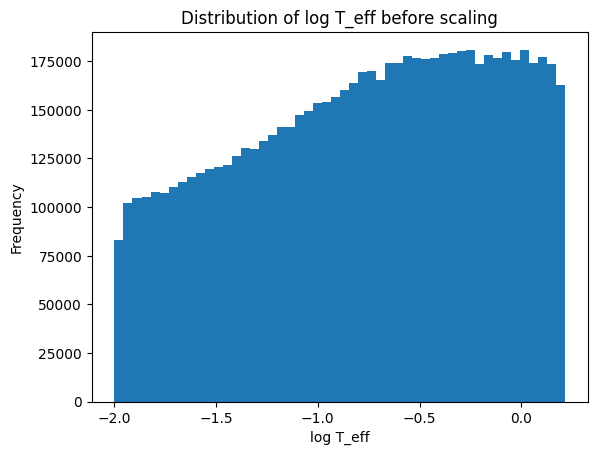

In [7]:
# Check for outliers in the original data (before scaling)
for i in range(5):
    original_log_teff = outputs[:, i]  # Assuming index 0 is log T_eff
    print("Log Teff distribution:", f"Mean: {original_log_teff.mean():.4f}", f"Std: {original_log_teff.std():.4f}")

# Plot histogram to visualize distribution
import matplotlib.pyplot as plt
plt.hist(original_log_teff, bins=50)
plt.title('Distribution of log T_eff before scaling')
plt.xlabel('log T_eff')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Check for any NaN or infinity values in your data
print("NaN values in outputs:", np.isnan(outputs).any())
print("Infinity values in outputs:", np.isinf(outputs).any())

# Find extreme values in the scaled data
extreme_indices = np.where(np.abs(y_train[:,0]) > 5)[0]
if len(extreme_indices) > 0:
    print("Original log T_eff values for extreme scaled points:")
    for idx in extreme_indices[:10]:  # Show first 10 if there are many
        print(f"Original: {outputs[idx,0]:.6f}, Scaled: {y_train[idx,0]:.6f}")

# Double-check the scaler's parameters
print("Scaler mean for log T_eff:", scaler_y.mean_[0])
print("Scaler scale (std) for log T_eff:", scaler_y.scale_[0])

NaN values in outputs: False
Infinity values in outputs: False
Original log T_eff values for extreme scaled points:
Original: 3.723974, Scaled: 6.105923
Original: 3.705551, Scaled: 5.011358
Original: 3.700226, Scaled: 5.959577
Original: 3.703997, Scaled: 7.618138
Original: 3.700713, Scaled: 6.078752
Original: 3.664686, Scaled: 6.565007
Original: 3.662084, Scaled: 6.553913
Original: 3.664655, Scaled: 6.685566
Original: 3.664633, Scaled: 7.140959
Original: 3.653417, Scaled: 6.298996
Scaler mean for log T_eff: 3.693333154614911
Scaler scale (std) for log T_eff: 0.03436089683268369


In [5]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    
# Load data
inputs, outputs, output_names, track_indices = load_data()
    
# Split data with same random state as in training
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

   
# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
    
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
    
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)
    

# Load the trained model
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
    
# Load model with map_location to handle device differences
model = GarstecNet.load_from_checkpoint(
    model_path, 
    input_dim=input_dim, 
    output_dim=output_dim,
    map_location=device
)
model.eval()  # Set to evaluation mode
model.to(device)  # Ensure model is on the correct device
    
# Make predictions on test data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()  # Move predictions back to CPU before converting to numpy
    
# Inverse transform predictions and actual values to get original scale
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)
    
# Calculate residuals
log_residuals = y_pred_original - y_test_original

# Convert predictions and test values from log to linear scale
# For the first 4 outputs (teff, luminosity, dnufit, numax) which were log-transformed
normal_pred = np.copy(y_pred_original)
normal_test = np.copy(y_test_original)

# Convert log outputs back to linear scale
for i in range(4):  # First 4 columns were log-transformed
    normal_pred[:, i] = 10**normal_pred[:, i]
    normal_test[:, i] = 10**normal_test[:, i]
# Note: FeH (index 4) was not log-transformed, so we leave it as is

# Calculate normal residuals
normal_residuals = normal_pred - normal_test


Using device: cuda


In [ ]:
# Calculate residuals without scaler!!

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    
# Load data
inputs, outputs, output_names, track_indices = load_data()
    
# Split data with same random state as in training
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)


# Load the trained model
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
    
# Load model with map_location to handle device differences
model = GarstecNet.load_from_checkpoint(
    model_path, 
    input_dim=input_dim, 
    output_dim=output_dim,
    map_location=device
)
model.eval()  # Set to evaluation mode
model.to(device)  # Ensure model is on the correct device
    
# Make predictions on test data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()  # Move predictions back to CPU before converting to numpy
    

# Calculate residuals
log_residuals = y_pred - y_test

# Convert predictions and test values from log to linear scale
# For the first 4 outputs (teff, luminosity, dnufit, numax) which were log-transformed
normal_pred = np.copy(y_pred)
normal_test = np.copy(y_test)

# Convert log outputs back to linear scale
for i in range(4):  # First 4 columns were log-transformed
    normal_pred[:, i] = 10**normal_pred[:, i]
    normal_test[:, i] = 10**normal_test[:, i]
# Note: FeH (index 4) was not log-transformed, so we leave it as is

# Calculate normal residuals
normal_residuals = normal_pred - normal_test


Using device: cuda


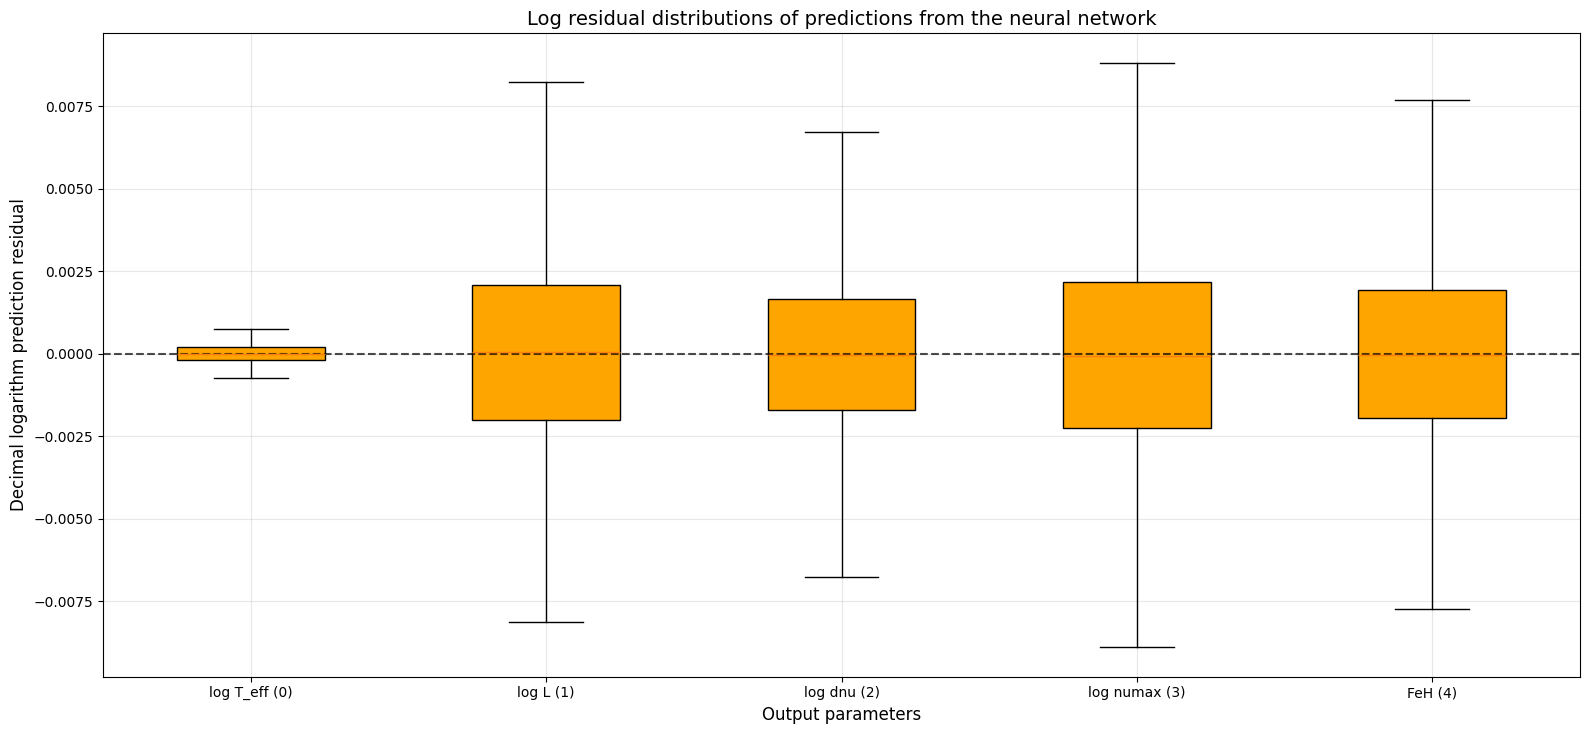

In [7]:
def log_residual_plots():
    
    plt.figure(figsize=(16, 8))
    
    # Prepare x-axis labels with indices
    x_labels = [f'{name} ({i})' for i, name in enumerate(output_names)]
    
    # Create boxplot
    boxplot = plt.boxplot(log_residuals, patch_artist=True, tick_labels=x_labels, showfliers=False)
    
    # Customize boxplot colors
    for box in boxplot['boxes']:
        box.set(facecolor='orange')  # Orange color similar to the reference image
    
    # Add horizontal line at y=0
    
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    
    # Customize plot
    plt.title('Log residual distributions of predictions from the neural network', fontsize=14)
    plt.xlabel('Output parameters', fontsize=12)
    plt.ylabel('Decimal logarithm prediction residual', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    
    # Adjust layout and save
    plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust for the figtext
    plt.show()
    

log_residual_plots()

In [7]:
def log_residual_stats():
    # Calculate and print statistics for each output parameter
    print("\nResidual Statistics:")
    print("====================")
    
    for i, name in enumerate(output_names):
        param_residuals = log_residuals[:, i]
        stats = {
            'Mean': np.mean(param_residuals),
            'Std Dev': np.std(param_residuals),
            '5th Percentile': np.percentile(param_residuals, 5),
            '25th Percentile': np.percentile(param_residuals, 25),
            'Median': np.median(param_residuals),
            '75th Percentile': np.percentile(param_residuals, 75),
            '95th Percentile': np.percentile(param_residuals, 95),
            'Min': np.min(param_residuals),
            'Max': np.max(param_residuals)
        }
        
        print(f"\n{name} (Parameter {i}):")
        for stat_name, value in stats.items():
            print(f"  {stat_name}: {value:.6f}")

log_residual_stats()


Residual Statistics:

log T_eff (Parameter 0):
  Mean: 0.000879
  Std Dev: 0.021132
  5th Percentile: -0.032030
  25th Percentile: -0.011416
  Median: 0.001585
  75th Percentile: 0.014649
  95th Percentile: 0.032509
  Min: -0.245726
  Max: 0.087961

log L (Parameter 1):
  Mean: -0.002047
  Std Dev: 0.283435
  5th Percentile: -0.414978
  25th Percentile: -0.202733
  Median: -0.038134
  75th Percentile: 0.171671
  95th Percentile: 0.524130
  Min: -0.833552
  Max: 1.154931

log dnu (Parameter 2):
  Mean: 0.002124
  Std Dev: 0.256408
  5th Percentile: -0.476961
  25th Percentile: -0.155264
  Median: 0.037943
  75th Percentile: 0.184699
  95th Percentile: 0.372260
  Min: -0.965867
  Max: 0.819077

log numax (Parameter 3):
  Mean: 0.003491
  Std Dev: 0.331992
  5th Percentile: -0.615314
  25th Percentile: -0.201406
  Median: 0.048550
  75th Percentile: 0.240422
  95th Percentile: 0.484258
  Min: -1.229545
  Max: 1.071611

FeH (Parameter 4):
  Mean: 0.003755
  Std Dev: 0.031124
  5th Percent

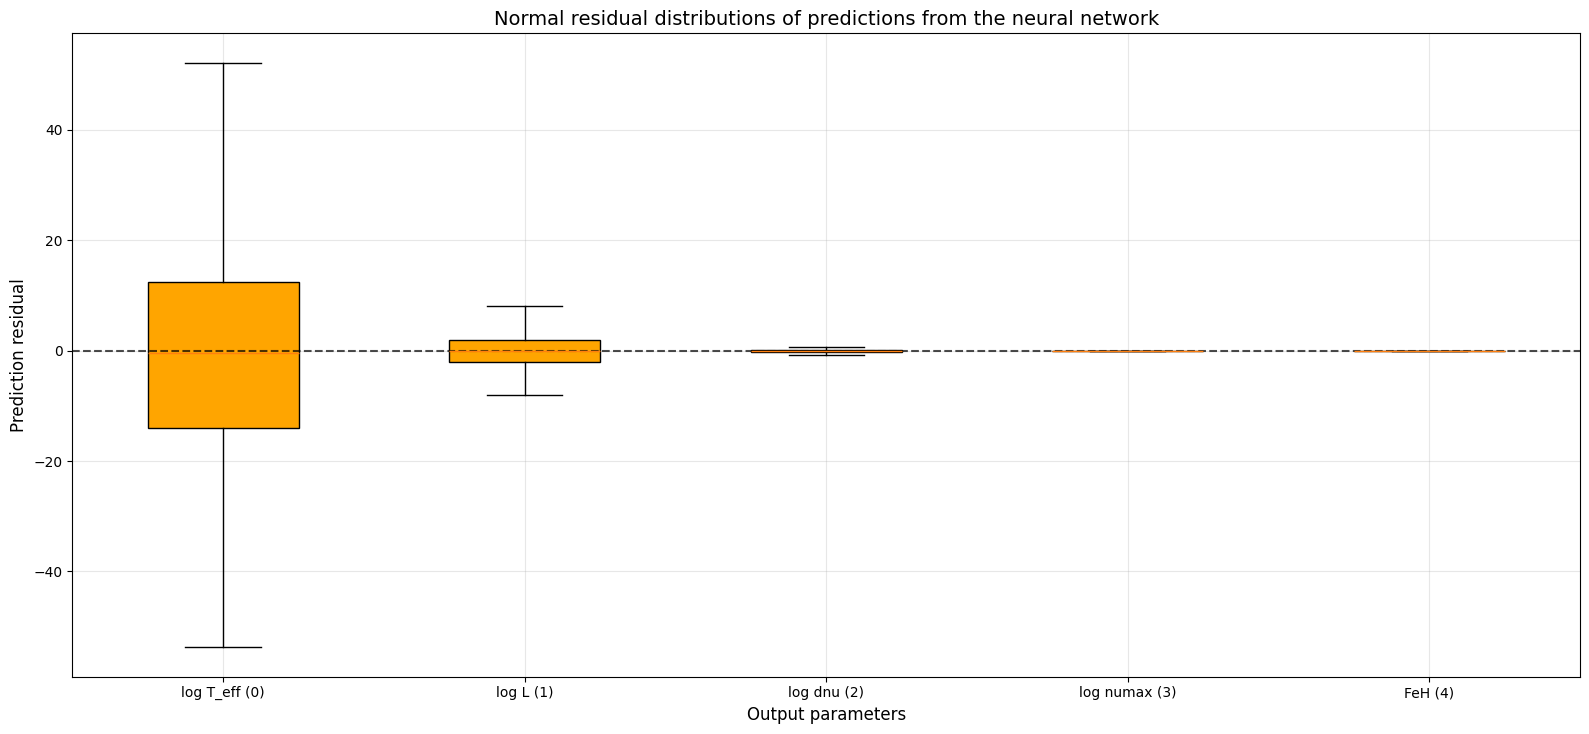

In [ ]:
def normal_residual_plots():
    
    plt.figure(figsize=(16, 8))
    
    # Prepare x-axis labels with indices
    x_labels = [f'{name} ({i})' for i, name in enumerate(output_names)]
    
    # Create boxplot
    boxplot = plt.boxplot(normal_residuals, patch_artist=True, tick_labels=x_labels, showfliers=False)
    
    # Customize boxplot colors
    for box in boxplot['boxes']:
        box.set(facecolor='orange')  # Orange color similar to the reference image
    
    # Add horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    
    # Customize plot
    plt.title('Normal residual distributions of predictions from the neural network', fontsize=14)
    plt.xlabel('Output parameters', fontsize=12)
    plt.ylabel('Prediction residual', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    
    # Adjust layout and save
    plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust for the figtext
    plt.show()
    

normal_residual_plots()

In [ ]:
def calculate_parameter_medians(original_test, original_pred):
    # Convert log values back to linear scale for the first 4 parameters
    normal_test = np.copy(original_test)
    for i in range(4):  # teff, luminosity, dnu, numax
        normal_test[:, i] = 10**normal_test[:, i]
    
    # Define parameter names
    param_names = ["Teff (K)", "Luminosity (L☉)", "Δν (μHz)", "ν_max (μHz)", "[Fe/H] (dex)"]
    
    # Calculate median for each parameter
    medians = np.median(normal_test, axis=0)
    
    # Print results in a formatted table
    print("Parameter Median Values from Dataset:")
    print("-" * 40)
    for name, median in zip(param_names, medians):
        if name == "[Fe/H] (dex)":
            print(f"{name:<20} {median:.3f}")
        else:
            print(f"{name:<20} {median:.2f}")
    
    return medians

# Call the function
median_values = calculate_parameter_medians(y_test_original, y_pred_original)

Parameter Median Values from Dataset:
----------------------------------------
Teff (K)             4953.89
Luminosity (L☉)      55.89
Δν (μHz)             3.97
ν_max (μHz)          0.01
[Fe/H] (dex)         -0.728


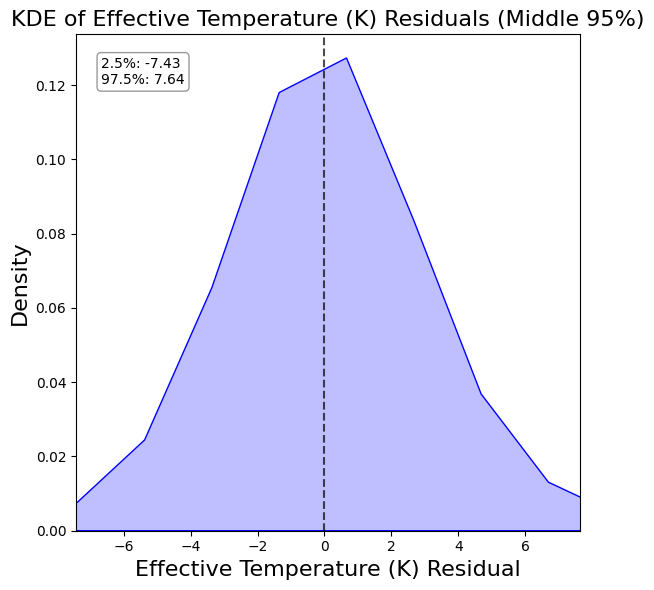

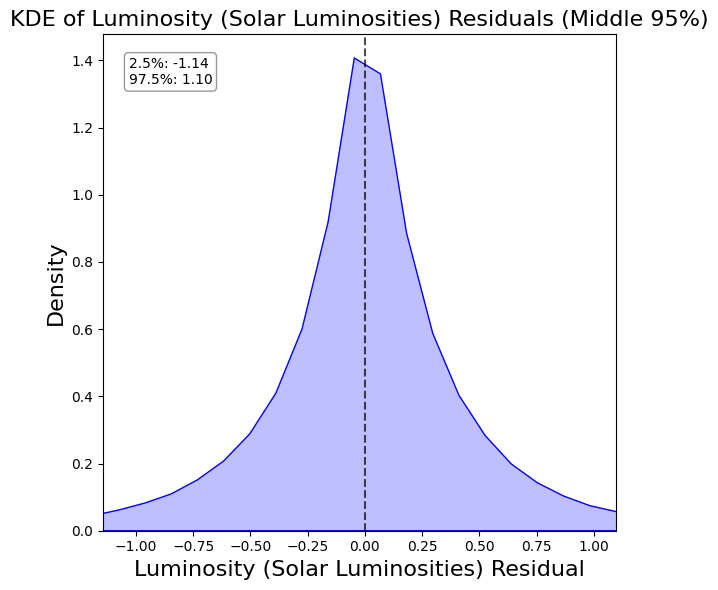

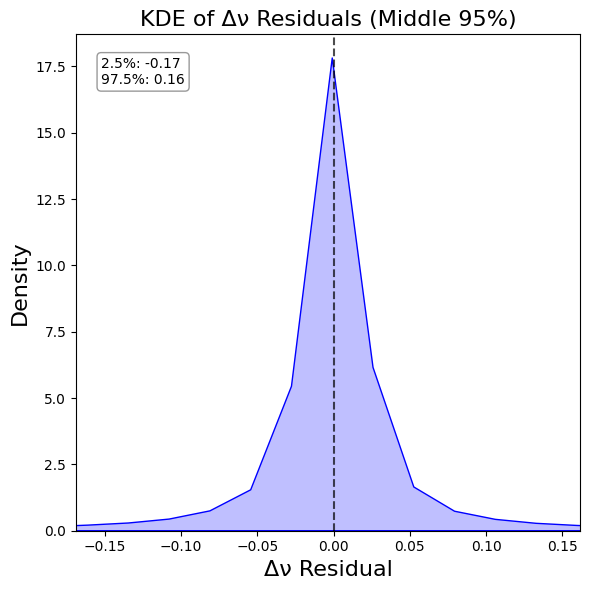

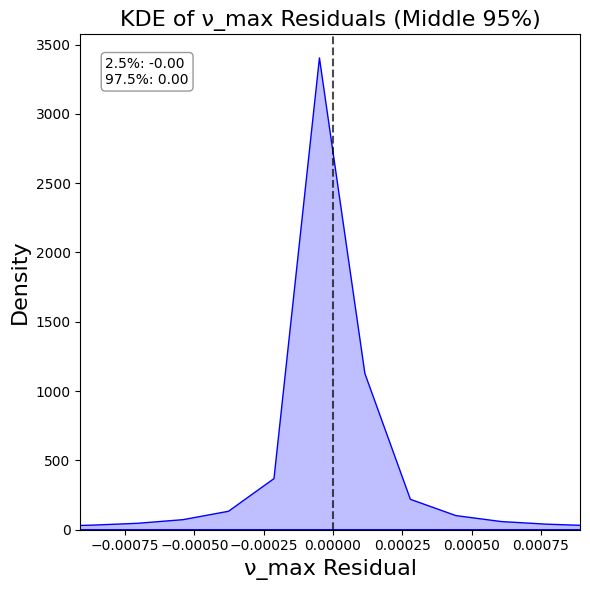

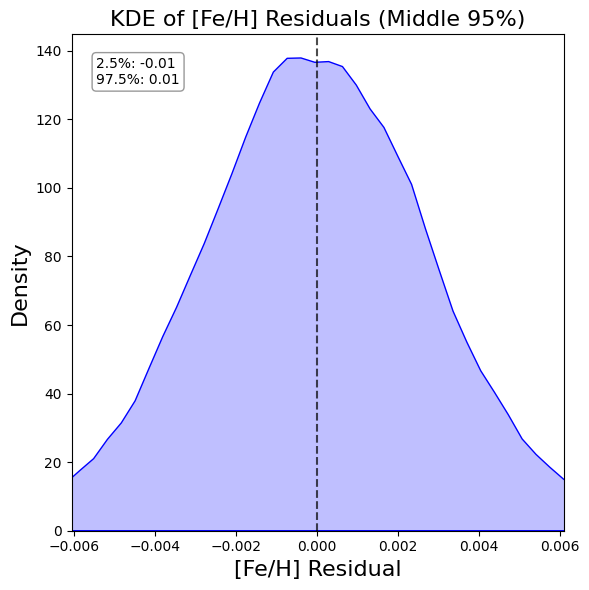

In [ ]:
def individual_kde_plots():
    # Define parameter names for each column of normal_residuals
    names = ["Effective Temperature (K)", "Luminosity (Solar Luminosities)", "Δν", "ν_max", "[Fe/H]"]
    
    # Iterate through each parameter
    for i, name in enumerate(names):
        # Extract residuals for current parameter
        residual = normal_residuals[:, i]
        
        # Calculate the 2.5th and 97.5th percentiles (middle 95%)
        lower_bound = np.percentile(residual, 2.5)
        upper_bound = np.percentile(residual, 97.5)
        
        plt.figure(figsize=(6, 6))
        
        # Create KDE plot
        sns.kdeplot(x=residual, fill=True, color='blue')
        
        # Add reference line at zero
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
        
        # Set x-axis limits to show only middle 95%
        plt.xlim(lower_bound, upper_bound)
        
        # Add title and labels
        plt.title(f'KDE of {name} Residuals (Middle 95%)', fontsize=16)
        plt.xlabel(f'{name} Residual', fontsize=16)
        plt.ylabel('Density', fontsize=16)
        
        # Display percentile values in a text box
        plt.annotate(f'2.5%: {lower_bound:.2f}\n97.5%: {upper_bound:.2f}', 
                    xy=(0.05, 0.9), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        plt.tight_layout()
        plt.show()

individual_kde_plots()

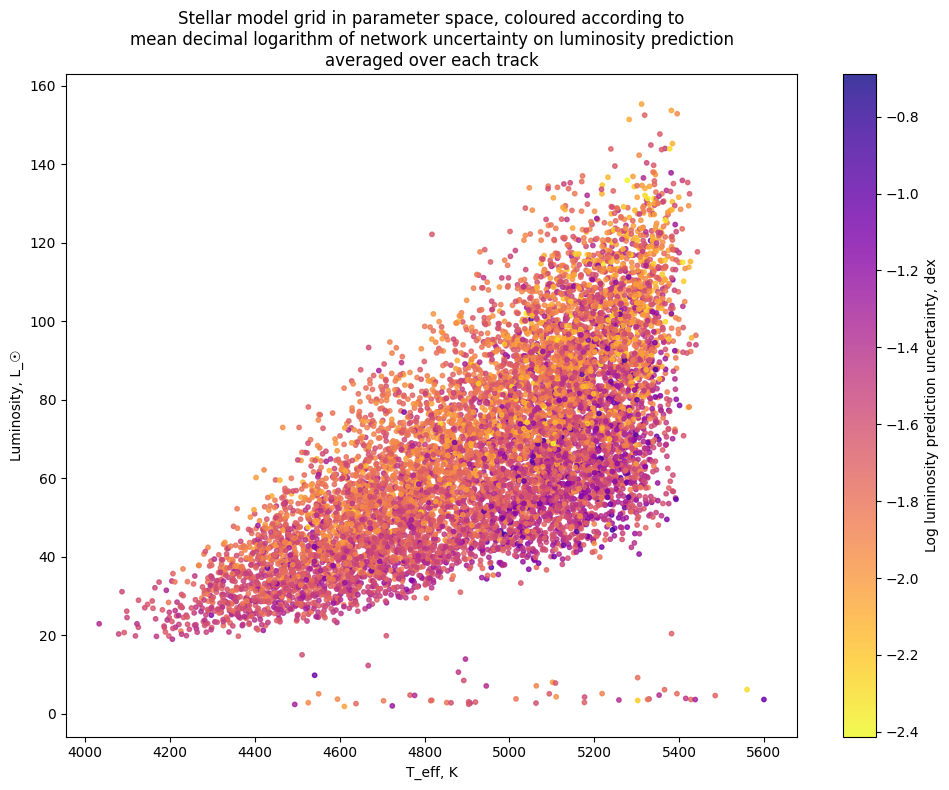

In [ ]:
def plot_model_grid_with_uncertainties():
    # First, ensure that track_indices matches the test set
    # We need track indices only for the test set, not the full dataset
    _, test_indices = train_test_split(range(len(inputs)), test_size=0.2, random_state=1)
    test_track_indices = track_indices[test_indices]
    
    # Extract unique tracks in the test set
    unique_tracks = np.unique(test_track_indices)
    
    # Prepare containers for median values
    median_teff = []
    median_lum = []
    track_residuals = []
    
    # For each track, calculate the median values and mean residual
    for track_idx in unique_tracks:
        # Get indices where test_track_indices equals this track
        mask = test_track_indices == track_idx
        indices = np.where(mask)[0]
        
        if len(indices) == 0:
            continue  # Skip if no points for this track in test set
            
        # Get original values and residuals for this track
        track_teff_original = 10**y_test_original[indices, 0]  # Convert from log10 back to linear scale
        track_lum_original = 10**y_test_original[indices, 1]
        
        # Calculate residuals for this track (for luminosity)
        track_lum_residuals = log_residuals[indices, 1]  # This is residual in log space
        
        # Calculate median values for this track
        median_teff.append(np.median(track_teff_original))
        median_lum.append(np.median(track_lum_original))
        
        # Calculate mean absolute residual for this track
        mean_abs_residual = np.mean(np.abs(track_lum_residuals))
        track_residuals.append(mean_abs_residual)
    
    # Convert to arrays
    median_teff = np.array(median_teff)
    median_lum = np.array(median_lum)
    track_residuals = np.array(track_residuals)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        median_teff, 
        median_lum, 
        c=np.log10(track_residuals + 1e-10),  # Log scale for residuals (add small value to avoid log(0))
        cmap='plasma_r',  
        s=10,  # Marker size
        alpha=0.8
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Log luminosity prediction uncertainty, dex')
    
    # Set axis labels and title
    plt.xlabel('T_eff, K')
    plt.ylabel('Luminosity, L_☉')
    plt.title('Stellar model grid in parameter space, coloured according to\n'
              'mean decimal logarithm of network uncertainty on luminosity prediction\n'
              'averaged over each track')
    
    # Use log scale if data spans multiple orders of magnitude
    #if np.max(median_lum)/np.min(median_lum) > 10:
    #   plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

plot_model_grid_with_uncertainties()

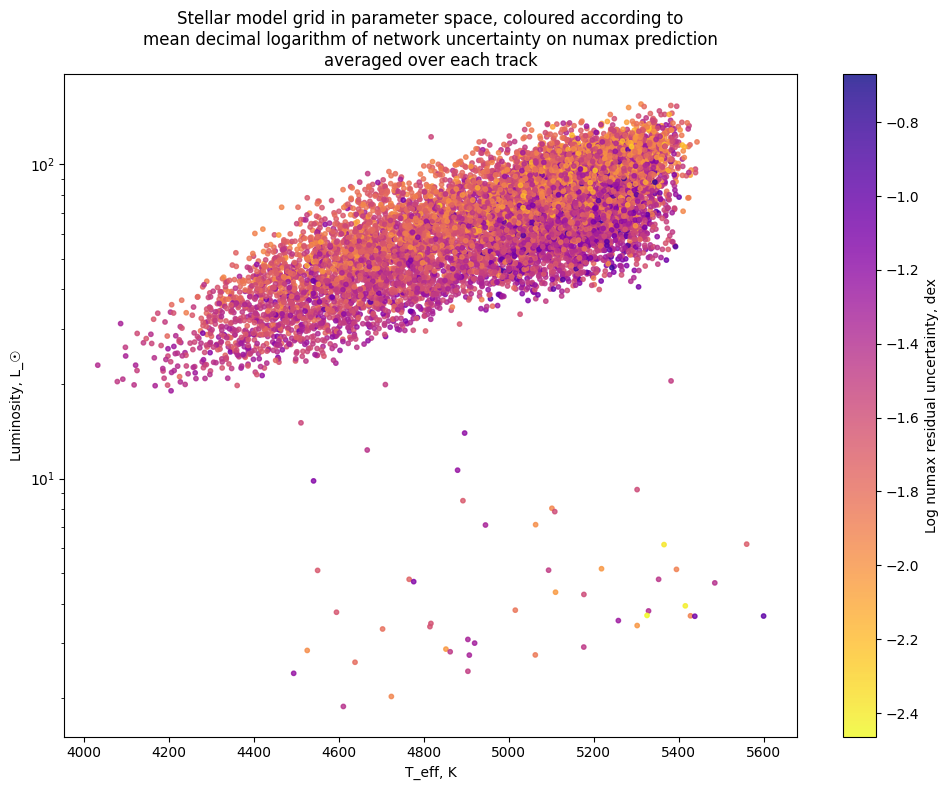

In [ ]:
def plot_model_grid_with_uncertainties_1():

# Same function as above but with colours according to numax residuals

    # First, ensure that track_indices matches the test set
    # We need track indices only for the test set, not the full dataset
    _, test_indices = train_test_split(range(len(inputs)), test_size=0.2, random_state=1)
    test_track_indices = track_indices[test_indices]
    
    # Extract unique tracks in the test set
    unique_tracks = np.unique(test_track_indices)
    
    # Prepare containers for median values and numax residuals
    median_teff = []
    median_lum = []
    track_residuals_numax = []  # Change this to store numax residuals
    
    # For each track, calculate the median values and mean residual for numax
    for track_idx in unique_tracks:
        # Get indices where test_track_indices equals this track
        mask = test_track_indices == track_idx
        indices = np.where(mask)[0]
        
        if len(indices) == 0:
            continue  # Skip if no points for this track in test set
            
        # Get original values and residuals for this track
        track_teff_original = 10**y_test_original[indices, 0]  # Convert from log10 back to linear scale
        track_lum_original = 10**y_test_original[indices, 1]
        track_numax_original = 10**y_test_original[indices, 3]  # Assuming numax is at index 3 in your original output
        
        # Calculate residuals for this track (for numax)
        track_numax_residuals = log_residuals[indices, 3]  # Residuals for numax (in log space)
        
        # Calculate median values for this track
        median_teff.append(np.median(track_teff_original))
        median_lum.append(np.median(track_lum_original))
        
        # Calculate mean absolute residual for numax (at the median point)
        mean_abs_residual_numax = np.mean(np.abs(track_numax_residuals))
        track_residuals_numax.append(mean_abs_residual_numax)
    
    # Convert to arrays
    median_teff = np.array(median_teff)
    median_lum = np.array(median_lum)
    track_residuals_numax = np.array(track_residuals_numax)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        median_teff, 
        median_lum, 
        c=np.log10(track_residuals_numax + 1e-10),  # Log scale for numax residuals (add small value to avoid log(0))
        cmap='plasma_r',
        s=10,  # Marker size
        alpha=0.8
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Log numax residual uncertainty, dex')
    
    # Set axis labels and title
    plt.xlabel('T_eff, K')
    plt.ylabel('Luminosity, L_☉')
    plt.title('Stellar model grid in parameter space, coloured according to\n'
              'mean decimal logarithm of network uncertainty on numax prediction\n'
              'averaged over each track')
    
    # Use log scale if data spans multiple orders of magnitude
    if np.max(median_lum)/np.min(median_lum) > 10:
        plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

plot_model_grid_with_uncertainties_1()
